# **1. Install packages**

In [3]:
%%capture
!pip install torchinfo

# **2. Import libraries**

In [4]:
# Data handling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

# Preprocessing
from sklearn.model_selection import train_test_split as tts

# Torch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision.models import vit_b_16, ViT_B_16_Weights

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

# os
import os

# OrderedDict
from collections import OrderedDict

# tqdm
from tqdm.auto import tqdm

# Path
from pathlib import Path

# random
import random

# typing
from typing import Dict, List

# warnings
import warnings
warnings.filterwarnings("ignore")

# **3. Load data and EDA**

In [5]:
# Total Images
IMAGE_PATH = Path("D:\\final_year\\cv\\mini_project\\archive\\files")

IMAGE_PATH_LIST = list(IMAGE_PATH.glob("*/*/*.jpg"))

print(f'Total Images = {len(IMAGE_PATH_LIST)}')

Total Images = 87


In [6]:
# number of images per class.
classes = os.listdir(IMAGE_PATH)
classes = sorted(classes)

print("**" * 20)
print(" " * 10, f"Total Classes = {len(classes)}")
print("**" * 20)

for c in classes:
    total_images_class = list(Path(os.path.join(IMAGE_PATH, c)).glob("*/*.jpg"))
    print(f"* {c}: {len(total_images_class)} images")

****************************************
           Total Classes = 3
****************************************
* acne: 30 images
* bags: 27 images
* redness: 30 images


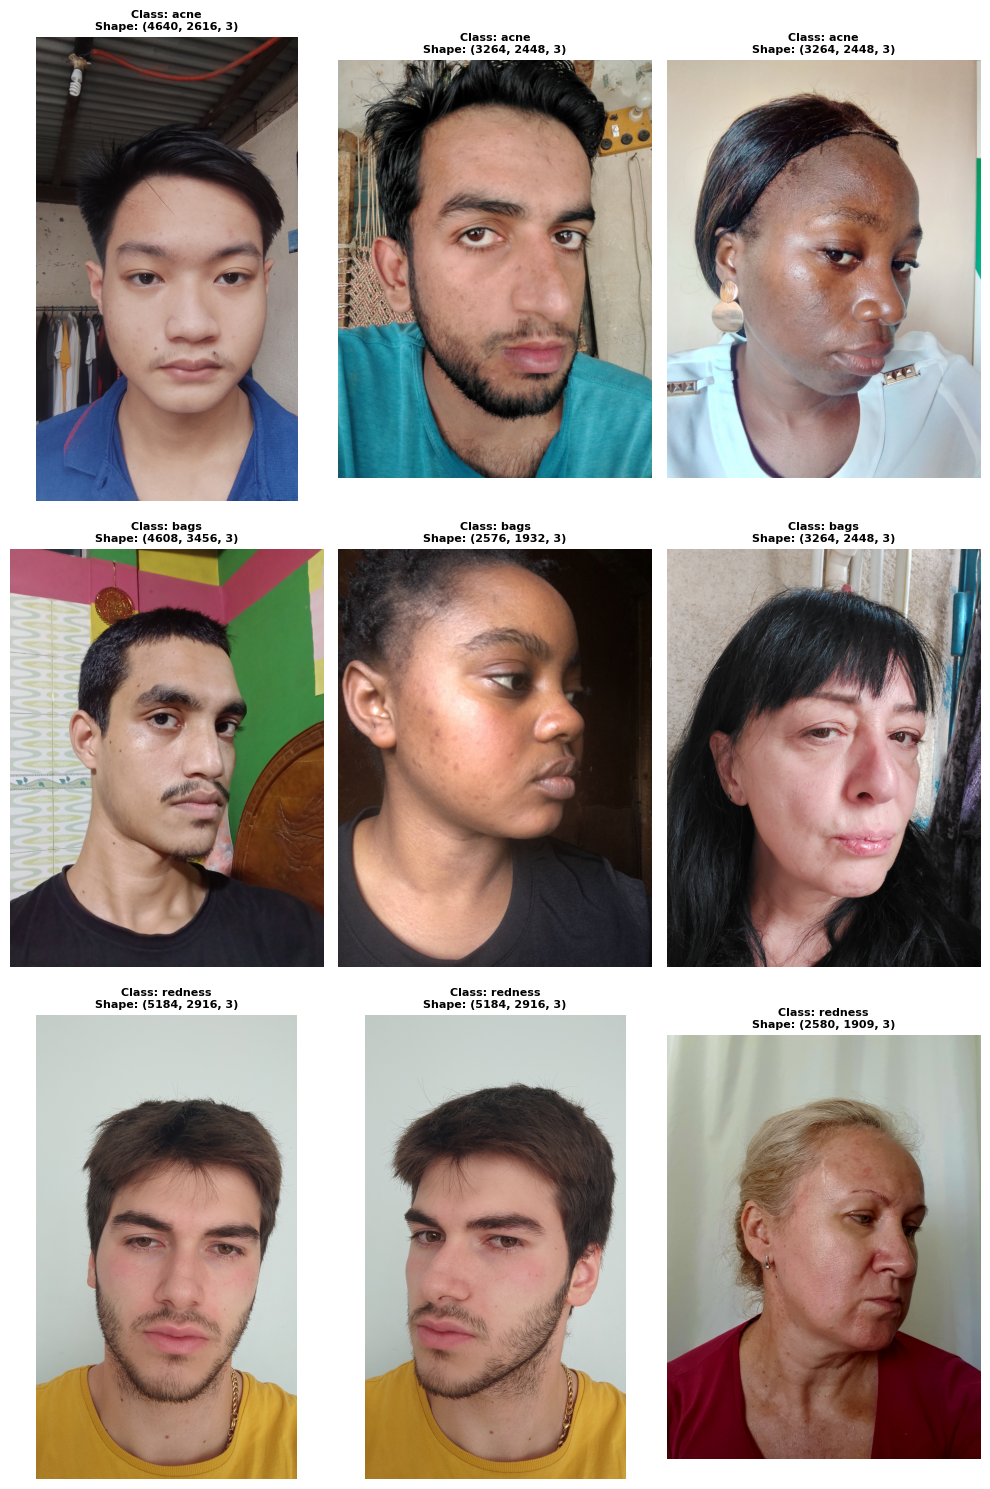

In [7]:
# We view some images for each class.
NUM_IMAGES = 3

fig, ax = plt.subplots(nrows = len(classes), ncols = NUM_IMAGES, figsize = (10,15))
p = 0
for c in classes:
    total_images_class = list(Path(os.path.join(IMAGE_PATH, c)).glob("*/*.jpg"))
    images_selected = random.choices(total_images_class, k = NUM_IMAGES)
    
    for i,img_path in enumerate(images_selected):
        img_bgr = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        ax[p,i].imshow(img_rgb)
        ax[p,i].axis("off")
        ax[p,i].set_title(f"Class: {c}\nShape: {img_rgb.shape}", fontsize = 8, fontweight = "bold", color = "black")
        
    p += 1
    
fig.tight_layout()
fig.show()

# **4. Preprocessing**

Let's create a dataframe with two columns:

- the first **path** call will store the paths of the images.
- the second call **label** that will contain the labels of each image.

In [8]:
images_path = [None] * len(IMAGE_PATH_LIST)
labels = [None] * len(IMAGE_PATH_LIST)

for i,image_path in enumerate(IMAGE_PATH_LIST):
    images_path[i] = image_path
    labels[i] = image_path.parent.parent.stem
    
df_path_and_label = pd.DataFrame({'path':images_path, 
                                  'label':labels})
df_path_and_label.head()

,path,label
0,D:\final_year\cv\mini_project\archive\files\ac...,acne
1,D:\final_year\cv\mini_project\archive\files\ac...,acne
2,D:\final_year\cv\mini_project\archive\files\ac...,acne
3,D:\final_year\cv\mini_project\archive\files\ac...,acne
4,D:\final_year\cv\mini_project\archive\files\ac...,acne


Now we have to divide our dataframe into 3 parts:

- **train = 70%**
- **valid = 15%**
- **test = 15%**

In [9]:
SEED = 123

df_train, df_rest = tts(df_path_and_label, 
                        test_size = 0.3, 
                        random_state = SEED, 
                        stratify = df_path_and_label["label"])

df_val, df_test = tts(df_rest, 
                      test_size = 0.5, 
                      random_state = SEED, 
                      stratify = df_rest["label"])

In [10]:
# We have to define the mapping of the classes to convert the labels to numbers.
label_map = dict(zip(classes, range(0, len(classes))))
label_map

{'acne': 0, 'bags': 1, 'redness': 2}

In [11]:
# Now we define the transformations that we are going to apply.
weights = ViT_B_16_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

Now we are going to create the **Dataset's** and **DataLoader's**.

Let's start with the **Dataset's**.

In [12]:
class CustomDataset(Dataset):
    def __init__(self, df:pd.DataFrame, transforms, label_map:dict):
        self.df = df
        self.transforms = transforms
        self.label_map = label_map
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        df_new = self.df.copy()
        df_new = df_new.reset_index(drop = True)
        df_new["label"] = df_new["label"].map(self.label_map)
        image_path = df_new.iloc[idx, 0]
        image = Image.open(image_path).convert("RGB")
        image = self.transforms(image)
        label = df_new.iloc[idx, 1]
        
        return image,label

In [13]:
train_dataset = CustomDataset(df_train, auto_transforms, label_map)
valid_dataset = CustomDataset(df_val, auto_transforms, label_map)

**DataLoader's**

In [26]:
BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset = train_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = True, 
                              num_workers = 0)
valid_dataloader = DataLoader(dataset = valid_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = True, 
                              num_workers = 0)

In [15]:
# Let's visualize the dimensions of a batch.
batch_images, batch_labels = next(iter(train_dataloader))

batch_images.shape, batch_labels.shape

(torch.Size([1, 3, 224, 224]), torch.Size([1]))

# **5. Model**

In [16]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.optim import lr_scheduler

# Use a deeper model like ResNet50
resnet = models.resnet50(pretrained=True)

# Fine-tune the entire model instead of freezing layers
# No need to freeze layers in this case
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 3)  # Modify final layer to match your classes

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet = resnet.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)

# Implement learning rate scheduler to adjust learning rate over time
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Set up data augmentation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Define your dataloaders (ensure train_dataloader applies these transforms)
# train_dataloader = DataLoader(...)

# Set the number of epochs
num_epochs = 25  # Train longer to fine-tune

# Training loop
for epoch in range(num_epochs):
    resnet.train()  # Set model to training mode

    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_images, batch_labels in train_dataloader:
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)
        
        # Forward pass
        outputs = resnet(batch_images)
        loss = criterion(outputs, batch_labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate running loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

    # Step the learning rate scheduler
    scheduler.step()
    
    # Print epoch loss and accuracy
    epoch_loss = running_loss / len(train_dataloader)
    epoch_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

# After training, you should save your model for future use
torch.save(resnet.state_dict(), 'resnet50_finetuned.pth')


Epoch [1/25], Loss: 1.4497, Accuracy: 25.00%
Epoch [2/25], Loss: 1.2005, Accuracy: 30.00%
Epoch [3/25], Loss: 1.2175, Accuracy: 31.67%
Epoch [4/25], Loss: 1.1566, Accuracy: 36.67%
Epoch [5/25], Loss: 1.1652, Accuracy: 38.33%
Epoch [6/25], Loss: 1.1933, Accuracy: 33.33%
Epoch [7/25], Loss: 1.1927, Accuracy: 41.67%
Epoch [8/25], Loss: 1.1819, Accuracy: 33.33%
Epoch [9/25], Loss: 1.1024, Accuracy: 30.00%
Epoch [10/25], Loss: 1.0988, Accuracy: 36.67%
Epoch [11/25], Loss: 1.0913, Accuracy: 41.67%
Epoch [12/25], Loss: 1.0736, Accuracy: 50.00%
Epoch [13/25], Loss: 1.0478, Accuracy: 50.00%
Epoch [14/25], Loss: 1.0432, Accuracy: 48.33%
Epoch [15/25], Loss: 1.0084, Accuracy: 61.67%
Epoch [16/25], Loss: 1.0004, Accuracy: 63.33%
Epoch [17/25], Loss: 0.9961, Accuracy: 61.67%
Epoch [18/25], Loss: 0.9905, Accuracy: 65.00%
Epoch [19/25], Loss: 0.9883, Accuracy: 65.00%
Epoch [20/25], Loss: 0.9819, Accuracy: 65.00%
Epoch [21/25], Loss: 0.9779, Accuracy: 66.67%
Epoch [22/25], Loss: 0.9724, Accuracy: 70.0

In [27]:
# Function to evaluate the model on test data
def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    test_loss = 0.0

    with torch.no_grad():  # Disable gradient calculation for inference
        for images, labels in valid_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate final test accuracy and loss
    accuracy = 100 * correct / total
    avg_loss = test_loss / len(test_loader)
    print(f"Test Accuracy: {accuracy:.2f}%, Test Loss: {avg_loss:.4f}")
    return accuracy

# Evaluate the model
test_accuracy = evaluate_model(resnet, valid_dataloader, device)

# Save the trained model (if satisfied with performance)
if test_accuracy > 90:  # Save only if accuracy is above 90%
    torch.save(resnet.state_dict(), 'resnet50_finetuned_best.pth')
    print("Model saved successfully!")


Test Accuracy: 38.46%, Test Loss: 1.3234


In [30]:
from torchvision import transforms

# Define test transforms
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor(),          # Convert the image to a PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

In [32]:
# Prediction function for new images
from PIL import Image

def predict_image(image_path, model, device, transforms):
    model.eval()  # Set to evaluation mode
    image = Image.open(image_path)
    image = transforms(image).unsqueeze(0)  # Apply transforms and add batch dimension
    image = image.to(device)

    with torch.no_grad():  # Disable gradient calculation
        output = model(image)
        _, predicted_class = torch.max(output.data, 1)
    
    return predicted_class.item()

# Example usage:
# Replace 'new_image_path' with the path of the image to be predicted

new_image_path = Path("C:\\Users\\hp\\OneDrive\\Desktop\\face.jpg")
predicted_class = predict_image(new_image_path, resnet, device, test_transforms)
print(f'Predicted class for the new image: {predicted_class}')

Predicted class for the new image: 1


In [22]:
# Set the model to evaluation mode
resnet.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy: {100 * correct / total:.2f}%')


NameError: name 'test_dataloader' is not defined

In [17]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load a pre-trained ResNet model (e.g., ResNet-18)
resnet = models.resnet18(pretrained=True)  

# Freeze the parameters if you're using ResNet as a feature extractor (optional)
for param in resnet.parameters():
    param.requires_grad = False


In [18]:
# Modify the final fully connected layer for your number of classes (e.g., 10)
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 3)  # 3 is the number of classes in your dataset


In [19]:
num_epochs = 10  # For example, train for 10 epochs


In [20]:
# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet = resnet.to(device)

# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.fc.parameters(), lr=0.001)  # Only optimizing the FC layer

# Training loop
for epoch in range(num_epochs):
    resnet.train()  # Set the model to training mode
    
    for batch_images, batch_labels in train_dataloader:
        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)
        
        # Forward pass
        outputs = resnet(batch_images)
        loss = criterion(outputs, batch_labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/10], Loss: 0.8262
Epoch [2/10], Loss: 0.9922
Epoch [3/10], Loss: 0.8048
Epoch [4/10], Loss: 1.0209
Epoch [5/10], Loss: 1.1852
Epoch [6/10], Loss: 1.3795
Epoch [7/10], Loss: 0.6433
Epoch [8/10], Loss: 1.8975
Epoch [9/10], Loss: 1.5715
Epoch [10/10], Loss: 1.2523


In [21]:
# Set the model to evaluation mode
resnet.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy: {100 * correct / total:.2f}%')


NameError: name 'test_dataloader' is not defined

In [ ]:
# Let's visualize the architecture of the model.
summary(model = model, 
        input_size = [1, 3, 224, 224], 
        col_names = ["input_size", "output_size", "num_params", "trainable"], 
        col_width = 15, 
        row_settings = ["var_names"])

We are going to **freeze the parameters of the conv_proj and encoder layers**.

In [ ]:
for param in model.conv_proj.parameters():
    param.requires_grad = False

In [ ]:
for param in model.encoder.parameters():
    param.requires_grad = False

In [ ]:
# Let's see if the parameters were frozen.
summary(model = model, 
        input_size = [1,3,224,224], 
        col_names = ["input_size", "output_size", "num_params", "trainable"], 
        col_width = 15,
        row_settings = ["var_names"])

Great!!, the parameters were frozen.

Let's visualize the last layer which we will modify the number of **out_features**, in this case it is the **number of classes we have**.

In [ ]:
output_shape = len(classes)

model.heads = nn.Sequential(OrderedDict([('head', nn.Linear(in_features = 768, 
                                                            out_features = output_shape))]))

In [ ]:
# One last time let's take a look if the last layer was modified.
summary(model = model, 
        input_size = [1,3,224,224], 
        col_names = ["input_size", "output_size", "num_params", "trainable"], 
        col_width = 15,
        row_settings = ["var_names"])

Let's define the **loss function** and the **optimizer**.

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

We are going to define 3 functions for training and one to store the best model:

- **train_step**
- **save_checkpoint**
- **valid_step**
- **train**

In [ ]:
def train_step(model:torch.nn.Module, 
               dataloader:torch.utils.data.DataLoader, 
               loss_fn:torch.nn.Module, 
               optimizer:torch.optim.Optimizer):
    
    model.train()
    
    train_loss = 0.
    train_accuracy = 0.
    
    for batch,(X,y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred_logit = model(X)
        loss = loss_fn(y_pred_logit, y)
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
        y_pred_class = torch.argmax(y_pred_prob, dim = 1)
        train_accuracy += accuracy_score(y.cpu().numpy(), 
                                         y_pred_class.detach().cpu().numpy())
        
    train_loss = train_loss/len(dataloader)
    train_accuracy = train_accuracy/len(dataloader)
    
    return train_loss, train_accuracy

In [ ]:
def save_checkpoint(filename, model, loss, epoch, optimizer, metric):
    state = {"filename":filename, 
             "model":model.state_dict(), 
             "loss":loss, 
             "epoch":epoch, 
             "optimizer":optimizer.state_dict(), 
             "metric":metric}
    
    torch.save(state, filename)

In [ ]:
def valid_step(model:torch.nn.Module, 
               dataloader:torch.utils.data.DataLoader, 
               loss_fn:torch.nn.Module):
    
    model.eval()
    
    valid_loss = 0.
    valid_accuracy = 0.
    
    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X,y = X.to(device), y.to(device)
            y_pred_logit = model(X)
            loss = loss_fn(y_pred_logit, y)
            valid_loss += loss.item()
            
            y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
            y_pred_class = torch.argmax(y_pred_prob, dim = 1)
            
            valid_accuracy += accuracy_score(y.cpu().numpy(), y_pred_class.detach().cpu().numpy())
            
    valid_loss = valid_loss/len(dataloader)
    valid_accuracy = valid_accuracy/len(dataloader)
    
    return valid_loss, valid_accuracy

In [ ]:
def train(model:torch.nn.Module, 
          train_dataloader:torch.utils.data.DataLoader, 
          valid_dataloader:torch.utils.data.DataLoader, 
          loss_fn:torch.nn.Module, 
          optimizer:torch.optim.Optimizer, 
          epochs:int = 10):
    
    results = {"train_loss":[], 
               "train_accuracy":[], 
               "valid_loss":[], 
               "valid_accuracy":[]}
    
    best_valid_loss = float("inf")
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train_step(model = model, 
                                                dataloader = train_dataloader, 
                                                loss_fn = loss_fn, 
                                                optimizer = optimizer)
        
        valid_loss, valid_accuracy = valid_step(model = model, 
                                                dataloader = valid_dataloader, 
                                                loss_fn = loss_fn)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            file_name = "best_model.pth"
            save_checkpoint(file_name, model, best_valid_loss, epoch, optimizer, valid_accuracy)
            
        print(f"Epoch: {epoch + 1} | ", 
              f"Train Loss: {train_loss:.4f} | ", 
              f"Train Accuracy: {train_accuracy:.4f} | ", 
              f"Valid Loss: {valid_loss:.4f} | ", 
              f"Valid Accuracy: {valid_accuracy:.4f}")
        
        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy)
        results["valid_loss"].append(valid_loss)
        results["valid_accuracy"].append(valid_accuracy)
        
    return results

In [ ]:
# Training!!!
EPOCHS = 100

torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

MODEL_RESULTS = train(model.to(device), 
                      train_dataloader, 
                      valid_dataloader, 
                      loss_fn, 
                      optimizer, 
                      EPOCHS)

In [ ]:
# Function to plot the loss and metric during each training epoch.
def loss_metric_curve_plot(model_results:Dict[str,List[float]]):
    
    train_loss = model_results["train_loss"]
    valid_loss = model_results["valid_loss"]
    
    train_accuracy = [float(value) for value in model_results["train_accuracy"]]
    valid_accuracy = [float(value) for value in model_results["valid_accuracy"]]
    
    fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))
    axes = axes.flat
    
    axes[0].plot(train_loss, color = "red", label = "Train")
    axes[0].plot(valid_loss, color = "blue", label = "Valid")
    axes[0].set_title("CrossEntropyLoss", fontsize = 12, fontweight = "bold", color = "black")
    axes[0].set_xlabel("Epochs", fontsize = 10, fontweight = "bold", color = "black")
    axes[0].set_ylabel("Loss", fontsize = 10, fontweight = "bold", color = "black")
    axes[0].legend()
    
    axes[1].plot(train_accuracy, color = "red", label = "Train")
    axes[1].plot(valid_accuracy, color = "blue", label = "Valid")
    axes[1].set_title("Metric of performance: Accuracy", fontsize = 12, fontweight = "bold", color = "black")
    axes[1].set_xlabel("Epochs", fontsize = 10, fontweight = "bold", color = "black")
    axes[1].set_ylabel("Score", fontsize = 10, fontweight = "bold", color = "black")
    axes[1].legend()
    
    fig.tight_layout()
    fig.show()

In [ ]:
loss_metric_curve_plot(MODEL_RESULTS)

In [ ]:
# Let's load the best model.
checkpoint_path = "/kaggle/working/best_model.pth"
checkpoint = torch.load(checkpoint_path)

In [ ]:
# Now let's look at the smallest loss, its metric and when it occurred.
print(f'Best Loss: {checkpoint["loss"]}')
print(f'Epoch: {checkpoint["epoch"] + 1}')
print(f'Best Metric: {checkpoint["metric"]}')

Well, now we have to predict the images of the test set.

- **Predictions**

In [ ]:
# First of all, we create the Dataset, DataLoader
test_dataset = CustomDataset(df_test, auto_transforms, label_map)
test_dataloader = DataLoader(dataset = test_dataset, shuffle = False, num_workers = 0)

In [ ]:
# We define the model again with its respective modification.
loaded_model = vit_b_16()

loaded_model.heads = nn.Sequential(OrderedDict([('head',nn.Linear(in_features = 768, 
                                                                  out_features = output_shape))]))

loaded_model.load_state_dict(checkpoint["model"])

# We now infer
loaded_model.to(device)

loaded_model.eval()

y_pred_test = []

with torch.inference_mode():
    for X,y in tqdm(test_dataloader):
        X,y = X.to(device), y.to(device)
        y_pred_logit = loaded_model(X)
        y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
        y_pred_class = torch.argmax(y_pred_prob, dim = 1)
        y_pred_test.append(y_pred_class.detach().cpu())

In [ ]:
y_pred_test = torch.cat(y_pred_test).numpy()

# **6. Metrics**

- **Accuracy**

In [ ]:
print(f'Accuracy = {round(accuracy_score(df_test["label"].map(label_map), y_pred_test), 4)}')

- **Confusion Matrix**

In [ ]:
confusion_matrix_test = confusion_matrix(df_test["label"].map(label_map), y_pred_test)

In [ ]:
fig,ax = plt.subplots(figsize = (15,4))
sns.heatmap(confusion_matrix_test, 
            cmap = 'coolwarm', 
            annot = True, 
            annot_kws = {"fontsize":9, "fontweight":"bold"}, 
            linewidths = 1.2, 
            linecolor = "black", 
            square = True, 
            xticklabels = classes, 
            yticklabels = classes, 
            cbar = False,
            ax = ax)
ax.set_title("Confusion Matrix Test", fontsize = 10, fontweight = "bold", color = "darkblue")
ax.tick_params('x',rotation = 90)
fig.show()